In [1]:
# https://www.kaggle.com/code/ambrosm/pss3e9-eda-which-makes-sense

# MLM

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train = pd.read_csv('./data/train.csv')
train.head(3)

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45


In [4]:
test = pd.read_csv('./data/test.csv')
test.head(3)

,id,SMILES,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TEST_000,CC(C)Nc1ccnc(N2CCN(Cc3cccs3)C(CCO)C2)n1,2.641,361.505,4,2,7,2.635,92.76
1,TEST_001,COc1cc(=O)n(-c2ccccc2)cc1C(=O)N1CCC2(CC1)OCCO2,0.585,370.399,5,0,3,0.585,68.31
2,TEST_002,Cc1cccc(NC(=N)/N=c2\nc(O)c(Cc3ccccc3)c(C)[nH]2)c1,4.276,347.414,4,4,5,4.290,92.86


In [5]:
sample = pd.read_csv('./data/sample_submission.csv')
sample.head(3)

,id,MLM,HLM
0,TEST_000,0,0
1,TEST_001,0,0
2,TEST_002,0,0


In [6]:
# column 순서 조절 및 'id' drop
new_column_order = ['id', 'MLM', 'HLM', 'SMILES', 'AlogP', 'Molecular_Weight',
                    'Num_H_Acceptors', 'Num_H_Donors', 'Num_RotatableBonds', 'LogD',
                    'Molecular_PolarSurfaceArea']

train = train[new_column_order]
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)
train.head(3)

,MLM,HLM,SMILES,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,26.010,50.680,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,3.259,400.495,5,2,8,3.259,117.37
1,29.270,50.590,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,2.169,301.407,2,1,2,2.172,73.47
2,5.586,80.892,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,1.593,297.358,5,0,3,1.585,62.45


In [7]:
test.head(3)

,SMILES,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,CC(C)Nc1ccnc(N2CCN(Cc3cccs3)C(CCO)C2)n1,2.641,361.505,4,2,7,2.635,92.76
1,COc1cc(=O)n(-c2ccccc2)cc1C(=O)N1CCC2(CC1)OCCO2,0.585,370.399,5,0,3,0.585,68.31
2,Cc1cccc(NC(=N)/N=c2\nc(O)c(Cc3ccccc3)c(C)[nH]2)c1,4.276,347.414,4,4,5,4.290,92.86


In [8]:
original_features = original_features = list(test.columns)
original_features.remove('SMILES')

target = 'MLM'

In [9]:
train.isna().sum()

MLM                           0
HLM                           0
SMILES                        0
AlogP                         2
Molecular_Weight              0
Num_H_Acceptors               0
Num_H_Donors                  0
Num_RotatableBonds            0
LogD                          0
Molecular_PolarSurfaceArea    0
dtype: int64

In [10]:
test.isna().sum()

SMILES                        0
AlogP                         1
Molecular_Weight              0
Num_H_Acceptors               0
Num_H_Donors                  0
Num_RotatableBonds            0
LogD                          0
Molecular_PolarSurfaceArea    0
dtype: int64

In [11]:
train['AlogP'].fillna(train['LogD'], inplace=True)
test['AlogP'].fillna(test['LogD'], inplace=True)

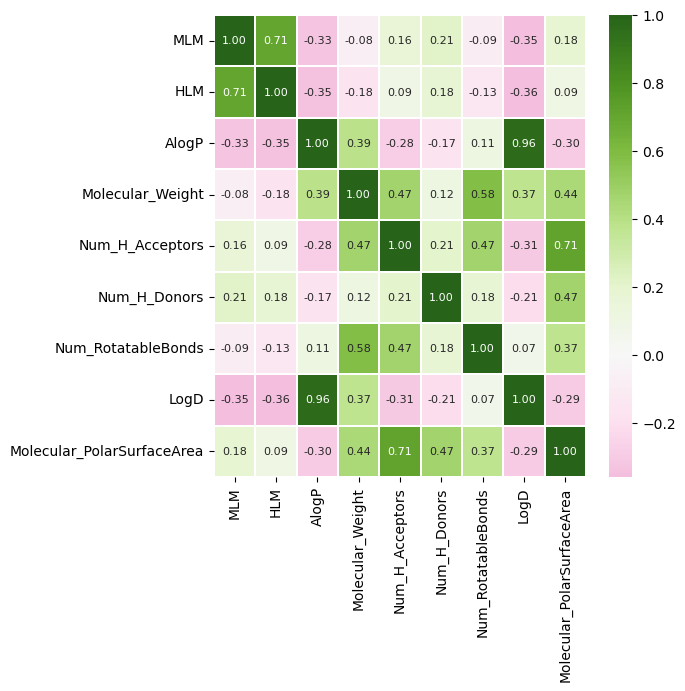

In [12]:
corr = train.corr(numeric_only = True)
plt.figure(figsize=(6,6))
sns.heatmap(corr, linewidth=0.1, fmt='.2f', 
            annot=True, annot_kws={'size': 8}, 
            cmap='PiYG', center=0)
plt.show()

In [13]:
%%time

from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor

result_list = []

def score_model(model, features_used, label=None):
    """Cross-validate a model with feature selection"""
    score_list = []
    oof = np.zeros_like(train[target])
    kf = KFold()
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train)):
        X_tr = train.iloc[idx_tr][features_used]
        X_va = train.iloc[idx_va][features_used]
        y_tr = train.iloc[idx_tr][target]
        y_va = train.iloc[idx_va][target]
        
        model.fit(X_tr, y_tr)
        trmse = mean_squared_error(y_tr, model.predict(X_tr), squared=False)
        y_va_pred = model.predict(X_va)
        rmse = mean_squared_error(y_va, y_va_pred, squared=False)
        if type(model) == Pipeline and type(model.steps[-1][1]) == GaussianProcessRegressor:
            print('Kernel:', model.steps[-1][1].kernel_)
        print(f"Fold {fold}: trmse = {trmse:.3f}   rmse = {rmse:.3f}")
        oof[idx_va] = y_va_pred
        score_list.append(rmse)

    rmse = sum(score_list) / len(score_list)
    print(f"Average rmse: {rmse:.3f}")
    if label is not None:
        global result_list
        result_list.append((label, rmse, oof))

score_model(model=make_pipeline(StandardScaler(), Ridge(70)),
            features_used=original_features)

Fold 0: trmse = 32.763   rmse = 32.084
Fold 1: trmse = 32.568   rmse = 32.826
Fold 2: trmse = 32.571   rmse = 32.943
Fold 3: trmse = 32.521   rmse = 33.056
Fold 4: trmse = 32.641   rmse = 32.511
Average rmse: 32.684
CPU times: total: 312 ms
Wall time: 404 ms


In [14]:
from sklearn.ensemble import RandomForestRegressor

score_model(model=RandomForestRegressor(n_estimators=300, min_samples_leaf=30, random_state=1),
            features_used=original_features,
            label='Random Forest')

Fold 0: trmse = 30.044   rmse = 31.658
Fold 1: trmse = 29.913   rmse = 31.870
Fold 2: trmse = 29.879   rmse = 32.095
Fold 3: trmse = 29.840   rmse = 32.310
Fold 4: trmse = 29.873   rmse = 32.304
Average rmse: 32.047


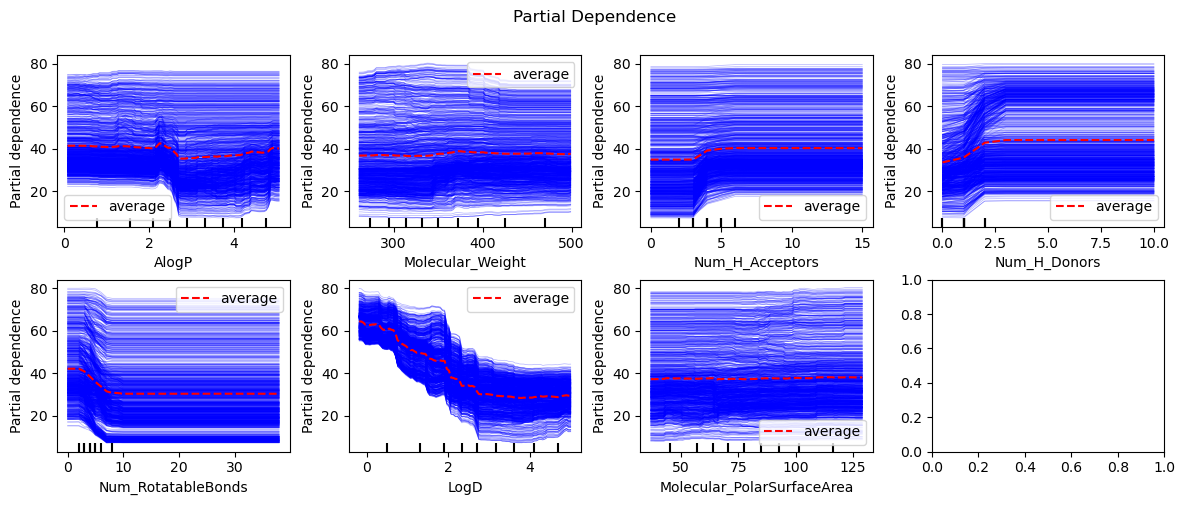

CPU times: total: 36.4 s
Wall time: 36.4 s


In [15]:
%%time

from sklearn.inspection import PartialDependenceDisplay

model = RandomForestRegressor(n_estimators=300, min_samples_leaf=30, random_state=1)
model.fit(train[original_features], train[target])

features_for_pdp = original_features
fig, axs = plt.subplots(2, 4, figsize=(12, 5))
plt.suptitle('Partial Dependence', y=1.0)
PartialDependenceDisplay.from_estimator(model, train[original_features],
                                        features_for_pdp,
                                        pd_line_kw={"color": "red"},
                                        ice_lines_kw={"color": "blue"},
                                        kind='both',
                                        ax=axs.ravel()[:len(features_for_pdp)])
plt.tight_layout(h_pad=0.3, w_pad=0.5)
plt.show()

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_params = {'n_estimators': 550,
              'max_depth': 4,
              'learning_rate': 0.01,
              'min_samples_leaf': 30 ,
              'max_features': 3}

score_model(model=GradientBoostingRegressor(**gbr_params, random_state=1),
            features_used=original_features,
            label='GradientBoostingRegressor')

Fold 0: trmse = 29.667   rmse = 31.459
Fold 1: trmse = 29.501   rmse = 31.446
Fold 2: trmse = 29.534   rmse = 31.921
Fold 3: trmse = 29.537   rmse = 32.150
Fold 4: trmse = 29.414   rmse = 31.918
Average rmse: 31.779


In [17]:
%%time

from sklearn.ensemble import VotingRegressor
from sklearn.compose import ColumnTransformer

ensemble_model = VotingRegressor(
    [('gb', make_pipeline(ColumnTransformer([('pt', 'passthrough', original_features)]),
                          GradientBoostingRegressor(**gbr_params, random_state=1))),
     ('rf', make_pipeline(ColumnTransformer([('pt', 'passthrough', original_features)]),
                          RandomForestRegressor(n_estimators=300, min_samples_leaf=30,
                                                random_state=1))),
     ('ridge', make_pipeline(ColumnTransformer([('pt', 'passthrough', original_features)]),
                             StandardScaler(),
                             Ridge(70))),
    ],
    weights=[0.8, 0.1, 0.1])
score_model(model=ensemble_model,
            features_used=test.columns,
            label='GradientBoostingRegressor + RF + Ridge')

Fold 0: trmse = 29.867   rmse = 31.408
Fold 1: trmse = 29.713   rmse = 31.464
Fold 2: trmse = 29.737   rmse = 31.913
Fold 3: trmse = 29.730   rmse = 32.133
Fold 4: trmse = 29.639   rmse = 31.883
Average rmse: 31.760
CPU times: total: 16 s
Wall time: 16.1 s


In [18]:
result_df = pd.DataFrame(result_list, columns=['label', 'rmse', 'oof'])
result_df.sort_values('rmse', inplace=True)
result_df.drop('oof', axis = 1, inplace= True)
result_df

,label,rmse
2,GradientBoostingRegressor + RF + Ridge,31.760212
1,GradientBoostingRegressor,31.778767
0,Random Forest,32.047417


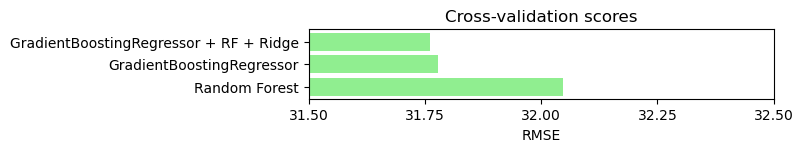

In [19]:
plt.figure(figsize=(6, len(result_df) * 0.3))
plt.title('Cross-validation scores')
plt.barh(np.arange(len(result_df)), result_df.rmse, color='lightgreen')
plt.gca().invert_yaxis()
plt.yticks(np.arange(len(result_df)), result_df.label)
plt.xticks(np.linspace(31.5, 32.5, 5))
plt.xlabel('RMSE')
plt.xlim(31.5, 32.5)
plt.show()

In [20]:
%%time
ensemble_model.fit(train[test.columns], train[target])
y_pred = ensemble_model.predict(test[test.columns])
answer_MLM = pd.Series(y_pred, index=test.index, name=target)

CPU times: total: 5.16 s
Wall time: 5.2 s


# HLM

In [21]:
train = pd.read_csv('./data/train.csv')
train.head(3)

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45


In [22]:
test = pd.read_csv('./data/test.csv')
test.head(3)

,id,SMILES,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TEST_000,CC(C)Nc1ccnc(N2CCN(Cc3cccs3)C(CCO)C2)n1,2.641,361.505,4,2,7,2.635,92.76
1,TEST_001,COc1cc(=O)n(-c2ccccc2)cc1C(=O)N1CCC2(CC1)OCCO2,0.585,370.399,5,0,3,0.585,68.31
2,TEST_002,Cc1cccc(NC(=N)/N=c2\nc(O)c(Cc3ccccc3)c(C)[nH]2)c1,4.276,347.414,4,4,5,4.290,92.86


In [23]:
sample = pd.read_csv('./data/sample_submission.csv')
sample.head(3)

,id,MLM,HLM
0,TEST_000,0,0
1,TEST_001,0,0
2,TEST_002,0,0


In [24]:
# column 순서 조절 및 'id' drop
new_column_order = ['id', 'MLM', 'HLM', 'SMILES', 'AlogP', 'Molecular_Weight',
                    'Num_H_Acceptors', 'Num_H_Donors', 'Num_RotatableBonds', 'LogD',
                    'Molecular_PolarSurfaceArea']

train = train[new_column_order]
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)
train.head(3)

,MLM,HLM,SMILES,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,26.010,50.680,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,3.259,400.495,5,2,8,3.259,117.37
1,29.270,50.590,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,2.169,301.407,2,1,2,2.172,73.47
2,5.586,80.892,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,1.593,297.358,5,0,3,1.585,62.45


In [25]:
test.head(3)

,SMILES,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,CC(C)Nc1ccnc(N2CCN(Cc3cccs3)C(CCO)C2)n1,2.641,361.505,4,2,7,2.635,92.76
1,COc1cc(=O)n(-c2ccccc2)cc1C(=O)N1CCC2(CC1)OCCO2,0.585,370.399,5,0,3,0.585,68.31
2,Cc1cccc(NC(=N)/N=c2\nc(O)c(Cc3ccccc3)c(C)[nH]2)c1,4.276,347.414,4,4,5,4.290,92.86


In [26]:
original_features = original_features = list(test.columns)
original_features.remove('SMILES')

target = 'HLM'

In [27]:
train['AlogP'].fillna(train['LogD'], inplace=True)
test['AlogP'].fillna(test['LogD'], inplace=True)

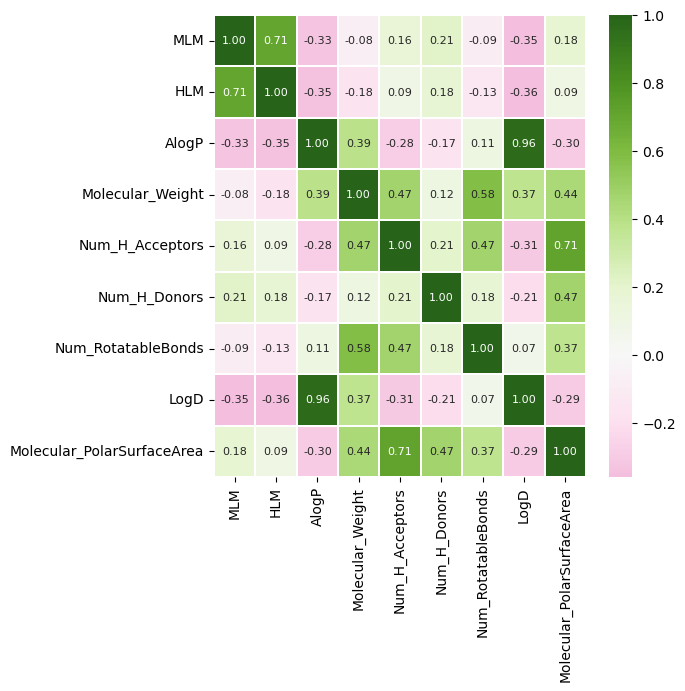

In [28]:
corr = train.corr(numeric_only = True)
plt.figure(figsize=(6,6))
sns.heatmap(corr, linewidth=0.1, fmt='.2f', 
            annot=True, annot_kws={'size': 8}, 
            cmap='PiYG', center=0)
plt.show()

In [29]:
%%time

from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor

result_list = []

def score_model(model, features_used, label=None):
    """Cross-validate a model with feature selection"""
    score_list = []
    oof = np.zeros_like(train[target])
    kf = KFold()
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train)):
        X_tr = train.iloc[idx_tr][features_used]
        X_va = train.iloc[idx_va][features_used]
        y_tr = train.iloc[idx_tr][target]
        y_va = train.iloc[idx_va][target]
        
        model.fit(X_tr, y_tr)
        trmse = mean_squared_error(y_tr, model.predict(X_tr), squared=False)
        y_va_pred = model.predict(X_va)
        rmse = mean_squared_error(y_va, y_va_pred, squared=False)
        if type(model) == Pipeline and type(model.steps[-1][1]) == GaussianProcessRegressor:
            print('Kernel:', model.steps[-1][1].kernel_)
        print(f"Fold {fold}: trmse = {trmse:.3f}   rmse = {rmse:.3f}")
        oof[idx_va] = y_va_pred
        score_list.append(rmse)

    rmse = sum(score_list) / len(score_list)
    print(f"Average rmse: {rmse:.3f}")
    if label is not None:
        global result_list
        result_list.append((label, rmse, oof))

score_model(model=make_pipeline(StandardScaler(), Ridge(70)),
            features_used=original_features)

Fold 0: trmse = 33.115   rmse = 32.954
Fold 1: trmse = 32.920   rmse = 33.687
Fold 2: trmse = 33.034   rmse = 33.334
Fold 3: trmse = 33.023   rmse = 33.335
Fold 4: trmse = 33.227   rmse = 32.476
Average rmse: 33.157
CPU times: total: 46.9 ms
Wall time: 56 ms


In [30]:
from sklearn.ensemble import RandomForestRegressor

score_model(model=RandomForestRegressor(n_estimators=300, min_samples_leaf=30, random_state=1),
            features_used=original_features,
            label='Random Forest')

Fold 0: trmse = 30.507   rmse = 32.621
Fold 1: trmse = 30.484   rmse = 32.584
Fold 2: trmse = 30.440   rmse = 32.707
Fold 3: trmse = 30.323   rmse = 33.112
Fold 4: trmse = 30.667   rmse = 32.109
Average rmse: 32.627


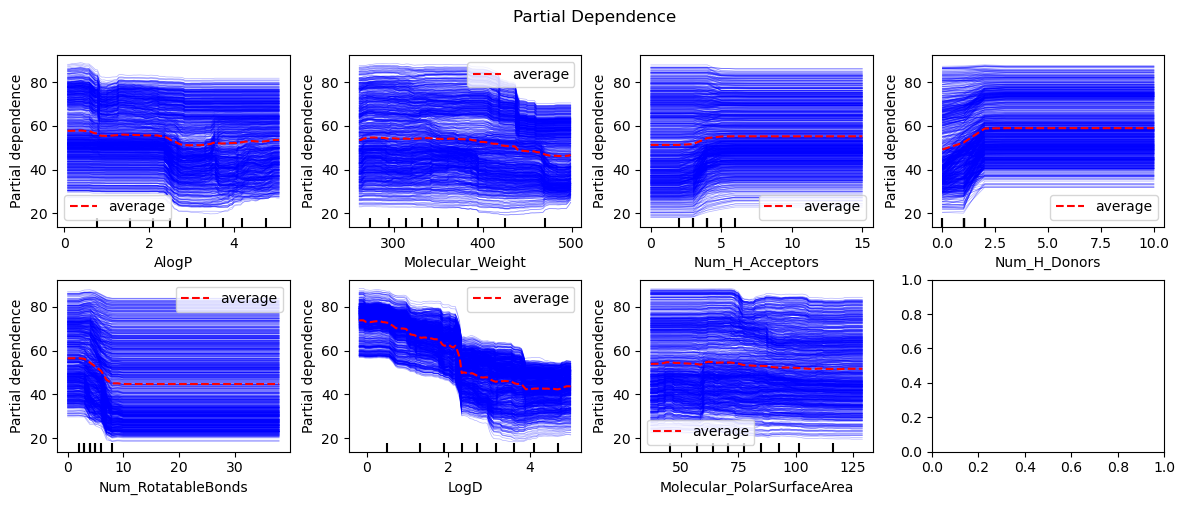

CPU times: total: 44.7 s
Wall time: 45.2 s


In [31]:
%%time

from sklearn.inspection import PartialDependenceDisplay

model = RandomForestRegressor(n_estimators=300, min_samples_leaf=30, random_state=1)
model.fit(train[original_features], train[target])

features_for_pdp = original_features
fig, axs = plt.subplots(2, 4, figsize=(12, 5))
plt.suptitle('Partial Dependence', y=1.0)
PartialDependenceDisplay.from_estimator(model, train[original_features],
                                        features_for_pdp,
                                        pd_line_kw={"color": "red"},
                                        ice_lines_kw={"color": "blue"},
                                        kind='both',
                                        ax=axs.ravel()[:len(features_for_pdp)])
plt.tight_layout(h_pad=0.3, w_pad=0.5)
plt.show()

In [32]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_params = {'n_estimators': 550,
              'max_depth': 4,
              'learning_rate': 0.01,
              'min_samples_leaf': 30 ,
              'max_features': 3}

score_model(model=GradientBoostingRegressor(**gbr_params, random_state=1),
            features_used=original_features,
            label='GradientBoostingRegressor')

Fold 0: trmse = 30.411   rmse = 32.582
Fold 1: trmse = 30.388   rmse = 32.173
Fold 2: trmse = 30.270   rmse = 32.672
Fold 3: trmse = 30.225   rmse = 33.139
Fold 4: trmse = 30.440   rmse = 31.881
Average rmse: 32.489


In [33]:
%%time

from sklearn.ensemble import VotingRegressor
from sklearn.compose import ColumnTransformer

ensemble_model = VotingRegressor(
    [('gb', make_pipeline(ColumnTransformer([('pt', 'passthrough', original_features)]),
                          GradientBoostingRegressor(**gbr_params, random_state=1))),
     ('rf', make_pipeline(ColumnTransformer([('pt', 'passthrough', original_features)]),
                          RandomForestRegressor(n_estimators=300, min_samples_leaf=30,
                                                random_state=1))),
     ('ridge', make_pipeline(ColumnTransformer([('pt', 'passthrough', original_features)]),
                             StandardScaler(),
                             Ridge(70))),
    ],
    weights=[0.8, 0.1, 0.1])
score_model(model=ensemble_model,
            features_used=test.columns,
            label='GradientBoostingRegressor + RF + Ridge')

Fold 0: trmse = 30.577   rmse = 32.516
Fold 1: trmse = 30.553   rmse = 32.243
Fold 2: trmse = 30.448   rmse = 32.636
Fold 3: trmse = 30.402   rmse = 33.051
Fold 4: trmse = 30.630   rmse = 31.861
Average rmse: 32.461
CPU times: total: 17.9 s
Wall time: 18.1 s


In [34]:
result_df = pd.DataFrame(result_list, columns=['label', 'rmse', 'oof'])
result_df.sort_values('rmse', inplace=True)
result_df.drop('oof', axis = 1, inplace= True)
result_df

,label,rmse
2,GradientBoostingRegressor + RF + Ridge,32.461300
1,GradientBoostingRegressor,32.489417
0,Random Forest,32.626713


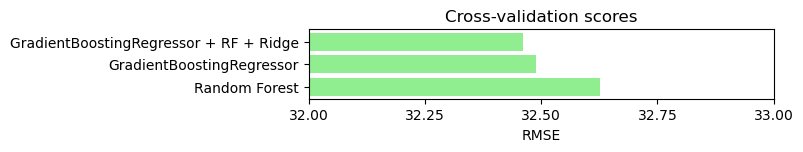

In [35]:
plt.figure(figsize=(6, len(result_df) * 0.3))
plt.title('Cross-validation scores')
plt.barh(np.arange(len(result_df)), result_df.rmse, color='lightgreen')
plt.gca().invert_yaxis()
plt.yticks(np.arange(len(result_df)), result_df.label)
plt.xticks(np.linspace(32, 33, 5))
plt.xlabel('RMSE')
plt.xlim(32, 33)
plt.show()

In [36]:
%%time
ensemble_model.fit(train[test.columns], train[target])
y_pred = ensemble_model.predict(test[test.columns])
answer_HLM = pd.Series(y_pred, index=test.index, name=target)

CPU times: total: 3.95 s
Wall time: 3.94 s


In [38]:
sample['MLM'] = answer_MLM
sample['HLM'] = answer_HLM

sample.to_csv(f"./submission/submission_06_kaggle_eda.csv", index = False, encoding = "utf-8-sig")
sample

,id,MLM,HLM
0,TEST_000,31.773895,49.608694
1,TEST_001,61.218492,78.499899
2,TEST_002,36.238544,49.821080
3,TEST_003,44.467747,67.290396
4,TEST_004,60.958755,74.099337
...,...,...,...
478,TEST_478,10.167524,29.410629
479,TEST_479,77.175368,87.139354
480,TEST_480,45.779357,70.554179
481,TEST_481,68.361470,81.917639
